# Dataset Preparation

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# Extract the table from online_retail.data.originals
dataset = online_retail.data.original

# Convert to a pandas DataFrame
import pandas as pd

df = pd.DataFrame(dataset)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
from datetime import date
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

# Setup BigQuery connection

In [ ]:
import os
from google.cloud import storage

# Define your GCS bucket and the key file path
bucket_name = 'g2-finalproject'
key_file_path = 'Credential/vertex.json'
local_key_path = '/tmp/service-account-file.json'

# Initialize a client
storage_client = storage.Client()

# Download the key file from GCS
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(key_file_path)
blob.download_to_filename(local_key_path)

# Set the environment variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = local_key_path

# Verify the environment variable is set correctly
print(f"GOOGLE_APPLICATION_CREDENTIALS is set to: {os.getenv('GOOGLE_APPLICATION_CREDENTIALS')}")

GOOGLE_APPLICATION_CREDENTIALS is set to: /tmp/service-account-file.json


In [ ]:
from google.colab import auth
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client(location="asia-southeast2")

In [ ]:
def run_query(query):
  query_job = client.query(query)  # Create an API request
  result = query_job.result() # Wait for the query to finish

  df_query = result.to_dataframe()
  return df_query

In [ ]:
query = """
SELECT *
FROM `finalproject-g2df12.retail.raw_dataiku`
LIMIT 10
"""

run_query(query)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536414,22139,None,56,2010-12-01 11:52:00,0.00,None,United Kingdom
1,536544,22077,6 RIBBONS RUSTIC CHARM,3,2010-12-01 14:32:00,3.36,None,United Kingdom
2,536544,22111,SCOTTIE DOG HOT WATER BOTTLE,2,2010-12-01 14:32:00,11.02,None,United Kingdom
3,536544,22080,RIBBON REEL POLKADOTS,1,2010-12-01 14:32:00,3.36,None,United Kingdom
4,536544,71459,HANGING JAM JAR T-LIGHT HOLDER,8,2010-12-01 14:32:00,1.69,None,United Kingdom
5,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,None,United Kingdom
6,536544,22037,ROBOT BIRTHDAY CARD,1,2010-12-01 14:32:00,0.85,None,United Kingdom
7,536544,22224,WHITE LOVEBIRD LANTERN,1,2010-12-01 14:32:00,5.91,None,United Kingdom
8,536544,22379,RECYCLING BAG RETROSPOT,2,2010-12-01 14:32:00,4.21,None,United Kingdom
9,536544,85064,CREAM SWEETHEART LETTER RACK,1,2010-12-01 14:32:00,11.02,None,United Kingdom


# Ingest DataFrame to GCS and BigQuery

In [ ]:
# Export DataFrame to CSV
csv_file_path = '/tmp/raw_data.csv'
df.to_csv(csv_file_path, index=False)

# Upload the CSV file to GCS
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob('Data/raw_data.csv')
blob.upload_from_filename(csv_file_path)

print(f"CSV file uploaded to: gs://{bucket_name}/{blob.name}")

CSV file uploaded to: gs://g2-finalproject/Data/raw_data.csv


In [ ]:
from google.cloud import bigquery

# Initialize a client
storage_client = storage.Client()
bigquery_client = bigquery.Client()

# Define project and dataset ID
project_id = 'finalproject-g2df12'
dataset_id = 'retail'
table = 'raw_data'

# Define the destination table
table_id = f'{project_id}.{dataset_id}.{table}'
csv_uri = f'gs://g2-finalproject/Data/raw_data.csv'

# Define schema
schema = [
    bigquery.SchemaField('InvoiceNo', 'STRING'),
    bigquery.SchemaField('StockCode', 'STRING'),
    bigquery.SchemaField('Description', 'STRING'),
    bigquery.SchemaField('Quantity', 'INTEGER'),
    bigquery.SchemaField('InvoiceDate', 'STRING'),
    bigquery.SchemaField('UnitPrice', 'FLOAT'),
    bigquery.SchemaField('CustomerID', 'FLOAT'),
    bigquery.SchemaField('Country', 'STRING')
]

# Load CSV data into BigQuery
job_config = bigquery.LoadJobConfig(
    schema=schema,
    skip_leading_rows=1,
    source_format=bigquery.SourceFormat.CSV
)
job = bigquery_client.load_table_from_uri(
    csv_uri,
    table_id,
    job_config=job_config
)

job.result()  # Waits for the job to complete.

table = bigquery_client.get_table(table_id)  # Make an API request.

In [ ]:
from google.cloud import bigquery
from google.colab import auth

# Create BigQuery client
client = bigquery.Client()

dataset_id = 'clv'
table_id = 'raw'
project_id = 'finalproject-g2df12'

from pandas_gbq import to_gbq

to_gbq(
    df,
    f'{dataset_id}.{table_id}',
    project_id=project_id,
    if_exists='replace'  # Options: 'fail', 'replace', 'append'
)

100%|██████████| 1/1 [00:00<00:00, 7436.71it/s]


# EDA with SQL

Urutan data preprocessingnya:
1. Rename column:
  - InvoiceID = transaction_id
  - StockCode = product_id
  - Description = product_name
  - Quantity = product_quantity
  - InvoiceDate = transaction_date
  - UnitPrice = price
  - CustomerID = customer_id
  - Country = customer_country

2. Ubah format `transaction_date` jadi DATETIME.

3. Ekstrak `transaction_date` untuk nambahin columns `year`, `month`, `day of week`, sama `week of year`.

4. Untuk column `transaction_id`, remove semua data yg depannya ada C nya. Itu cancelled transaction.

5. Untuk column `product_id`, ambil 5 digit pertama tanpa letter.

6. Untuk `customer_id`, semua missing value diisi 99999 aja.

7. Untuk `product_name`, missing value diisi modus (coba pakai join SQL).

8. Untuk `purchase_price`, yg nilainya 0 atau negatif di ganti pakai modus.

9. Untuk `product_quantity`, yg nilainya negatif di drop aja.

10. Untuk `customer_country`, ganti sesuai ini:
  - EIRE = Ireland
  - Channel Island = United Kingdom
  - RSA = South Africa

In [ ]:
query = """
SELECT

FROM
  `finalproject-g2df12.retail.raw_dataiku`
"""

run_query(query)

,StockCode
0,22139
1,22139
2,21134
3,22145
4,37509
...,...
1989,85175
1990,85175
1991,85175
1992,85175


# EDA with Python

## Data Preprocessing

In [ ]:
# Copy df to df_cleaned
df_cleaned = df.copy()

In [ ]:
# Summary statistics
df_cleaned.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


### Check missing values

In [ ]:
# Check for missing values
missing_values = df_cleaned.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
# Check rows with missing values
df_cleaned[df_cleaned.isnull().any(axis=1)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


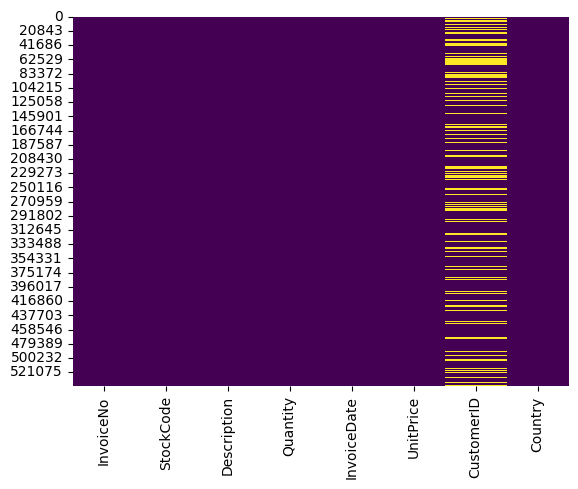

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_cleaned.isnull(), cbar=False, cmap='viridis')
plt.show()

In [ ]:
# Data check based on Data Catalog
print('Check if we had negative quantity and prices at same register:',
     'No' if df_cleaned[(df_cleaned.Quantity<0) & (df_cleaned.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')

print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      df_cleaned[(df_cleaned.Quantity<=0) & (df_cleaned.UnitPrice<=0)].shape[0])

print('\n% Negative Quantity: {:3.2%}'.format(df_cleaned[(df_cleaned.Quantity<0)].shape[0]/df_cleaned.shape[0]))

print('% Zero Quantity: {:3.2%}'.format(df_cleaned[(df_cleaned.Quantity==0)].shape[0]/df_cleaned.shape[0]))

print('\n% Negative Unit Price: {:3.2%}'.format(df_cleaned[(df_cleaned.UnitPrice<0)].shape[0]/df_cleaned.shape[0]))

print('% Zero Unit Price: {:3.2%}'.format(df_cleaned[(df_cleaned.UnitPrice==0)].shape[0]/df_cleaned.shape[0]))

print('\nAll register with negative quantity has Invoice start with:',
      df_cleaned.loc[(df_cleaned.Quantity<0) & ~(df_cleaned.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

print('\nCancelled registed with InvoiceID started with C: ',
      )

Check if we had negative quantity and prices at same register: No 

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336

% Negative Quantity: 1.96%
% Zero Quantity: 0.00%

% Negative Unit Price: 0.00%
% Zero Unit Price: 0.46%

All register with negative quantity has Invoice start with: ['C']

Cancelled registed with InvoiceID started with C: 


In [ ]:
print('Check register with UnitPrice negative:')
display(df_cleaned[(df_cleaned.UnitPrice<0)])

print("Sales records with Customer ID and zero in Unit Price:",df_cleaned[(df_cleaned.UnitPrice==0)  & ~(df_cleaned.CustomerID.isnull())].shape[0])
df_cleaned[(df_cleaned.UnitPrice==0)  & ~(df_cleaned.CustomerID.isnull())]

Check register with UnitPrice negative:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


Sales records with Customer ID and zero in Unit Price: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,1/13/2011 15:10,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2/10/2011 13:08,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,3/23/2011 10:25,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,3/30/2011 12:45,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,4/4/2011 14:42,0.0,14410.0,United Kingdom


### Cleaning

In [ ]:
# Data types
print(df_cleaned.dtypes)

# Unique values
for column in df_cleaned.columns:
    print(f"{column}: {df_cleaned[column].nunique()} unique values")

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
InvoiceNo: 25900 unique values
StockCode: 4070 unique values
Description: 4223 unique values
Quantity: 722 unique values
InvoiceDate: 23260 unique values
UnitPrice: 1630 unique values
CustomerID: 4372 unique values
Country: 38 unique values


Customer ID: Unique identifiers for customers. <br>
Invoice No: Transaction identifiers. <br>
StockCode: Product codes. <br>
Description: Descriptions of products. <br>
Quantity: Number of products. <br>
InvoiceDate: Dates of transactions. <br>
UnitPrice: Prices of products. <br>
Country: Countries where transactions were made.

#### Convert time and extract to week of year and day of month

In [ ]:
# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

df_cleaned.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [ ]:
# Extract Date Part
df_cleaned['Year'] = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Day'] = df_cleaned['InvoiceDate'].dt.day
df_cleaned['DayOfWeek'] = df_cleaned['InvoiceDate'].dt.dayofweek
df_cleaned['WeekOfYear'] = df_cleaned['InvoiceDate'].dt.isocalendar().week

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,2,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48


In [ ]:
df_cleaned['WeekOfYear'] = df_cleaned['WeekOfYear'].astype('int64')

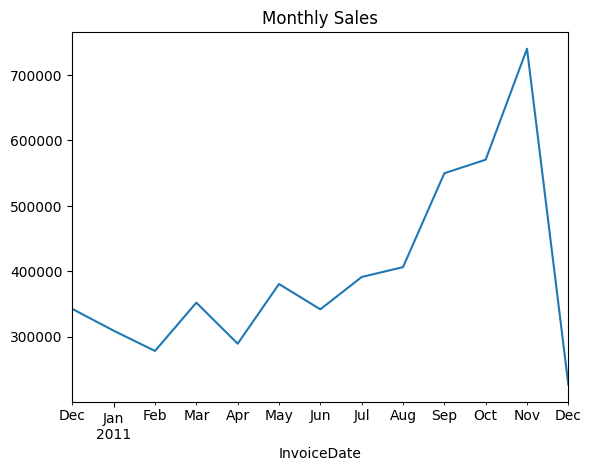

In [ ]:
# Transactions over time
df_cleaned.set_index('InvoiceDate')['Quantity'].resample('M').sum().plot()
plt.title('Monthly Sales')
plt.show()

#### Clean InvoiceNo column

In [ ]:
# Filter rows where length of 'InvoiceNo' is greater than 6
invoices_with_more_than_6_chars = df_cleaned[df_cleaned['InvoiceNo'].str.len() > 6]

# Filter rows where 'InvoiceNo' starts with 'c'
canceled_invoices = df_cleaned[df_cleaned['InvoiceNo'].str.startswith('C', na=False)]

print("\nNumber of canceled invoices:", canceled_invoices.shape[0])
print("\nNumber of invoices with more than 6 chars:", invoices_with_more_than_6_chars.shape[0])


Number of canceled invoices: 9288

Number of invoices with more than 6 chars: 9291


In [ ]:
canceled_invoices.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010,12,1,2,48
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010,12,1,2,48
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,1,2,48
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,2,48
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,2,48


In [ ]:
# Filter rows where length of 'InvoiceNo' is greater than 6 and 'InvoiceNo' does not start with 'C' or 'c'
invoices_with_more_than_6_chars_not_start_with_c = df_cleaned[
    (df_cleaned['InvoiceNo'].str.len() > 6) &
    (~df_cleaned['InvoiceNo'].str.startswith(('C', 'c')))
]

# Display the rows with 'InvoiceNo' that have more than 6 characters but do not start with 'C' or 'c'
print("Rows with 'InvoiceNo' that have more than 6 characters but do not start with 'C' or 'c':")
invoices_with_more_than_6_chars_not_start_with_c

Rows with 'InvoiceNo' that have more than 6 characters but do not start with 'C' or 'c':


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,2011,8,12,4,32
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,2011,8,12,4,32
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,2011,8,12,4,32


In [ ]:
# Filter rows where length of 'InvoiceNo' is 6 or fewer characters
df_cleaned = df_cleaned[df_cleaned['InvoiceNo'].str.len() <= 6]

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,2,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48


In [ ]:
# Count number of row before and after dropping invalid InvoiceID
print("Number of rows before dropping invalid InvoiceID:", df.shape[0])
print("Number of rows after dropping invalid InvoiceID:", df_cleaned.shape[0])
print("Number of dropped rows:", df.shape[0] - df_cleaned.shape[0])

Number of rows before dropping invalid InvoiceID: 541909
Number of rows after dropping invalid InvoiceID: 532618
Number of dropped rows: 9291


#### Clean StockCode column

In [ ]:
# Filter rows where length of 'StockCode' is greater than 5 from the cleaned dataframe
stock_code_more_than_5_chars = df_cleaned[df_cleaned['StockCode'].str.len() > 5]

print("Number of stock code with more than 5 chars:", stock_code_more_than_5_chars.shape[0])

Number of stock code with more than 5 chars: 51318


In [ ]:
# Remove any non-digit characters from the 'StockCode' column
df_cleaned.loc[:, 'StockCode'] = df_cleaned['StockCode'].str.replace(r'\D', '')

# Keep only the first 5 characters in case the resulting string is longer
df_cleaned.loc[:, 'StockCode'] = df_cleaned['StockCode'].str[:5]

# Filter rows where length of 'StockCode' is greater than 5 from the cleaned dataframe
stock_code_more_than_5_chars = df_cleaned[df_cleaned['StockCode'].str.len() > 5]

print("Number of stock code with more than 5 chars:", stock_code_more_than_5_chars.shape[0])

Number of stock code with more than 5 chars: 0


#### Clean CustomerID

In [ ]:
# Check for outliers (IDs outside the expected 5-digit range)
outliers = df_cleaned[(df_cleaned['CustomerID'] < 10000) | (df_cleaned['CustomerID'] > 99999)]
if not outliers.empty:
    print("Outliers found:")
    print(outliers)
else:
    print("No outliers found")

No outliers found


In [ ]:
# Calculate number and percentage of missing value in CustomerID
print("Number of missing values:", df_cleaned['CustomerID'].isnull().sum())
print("Percentage of missing values: {:.2%}".format(df_cleaned['CustomerID'].isnull().sum()/df_cleaned.shape[0]))

Number of missing values: 134694
Percentage of missing values: 25.29%


Because the percentage of missing value in CustomerID is pretty high, I want to fill the missing value of the CustomerID with 99999 instead so we don't need to drop the row but can identify that CustomerID 99999 is an invalid customer.

In [ ]:
# Fill missing values with a 99999
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].fillna(99999)

# Calculate number and percentage of missing value in CustomerID
print("Number of missing values:", df_cleaned['CustomerID'].isnull().sum())
print("Percentage of missing values: {:.2%}".format(df_cleaned['CustomerID'].isnull().sum()/df_cleaned.shape[0]))

Number of missing values: 0
Percentage of missing values: 0.00%


In [ ]:
# Converting to integer
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

df_cleaned.dtypes
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,48
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48


In [ ]:
df_cleaned.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
Year              0
Month             0
Day               0
DayOfWeek         0
WeekOfYear        0
dtype: int64

#### Missing values in Description

In [ ]:
# Drop rows where Description is missing to create the mapping
stock_description_map = df_cleaned.dropna(subset=['Description']).drop_duplicates(subset=['StockCode'])

# Create a mapping of StockCode to Description
stock_description_map = stock_description_map.set_index('StockCode')['Description'].to_dict()

stock_description_map

{'85123': 'WHITE HANGING HEART T-LIGHT HOLDER',
 '71053': 'WHITE METAL LANTERN',
 '84406': 'CREAM CUPID HEARTS COAT HANGER',
 '84029': 'KNITTED UNION FLAG HOT WATER BOTTLE',
 '22752': 'SET 7 BABUSHKA NESTING BOXES',
 '21730': 'GLASS STAR FROSTED T-LIGHT HOLDER',
 '22633': 'HAND WARMER UNION JACK',
 '22632': 'HAND WARMER RED POLKA DOT',
 '84879': 'ASSORTED COLOUR BIRD ORNAMENT',
 '22745': "POPPY'S PLAYHOUSE BEDROOM ",
 '22748': "POPPY'S PLAYHOUSE KITCHEN",
 '22749': 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 '22310': 'IVORY KNITTED MUG COSY ',
 '84969': 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 '22623': 'BOX OF VINTAGE JIGSAW BLOCKS ',
 '22622': 'BOX OF VINTAGE ALPHABET BLOCKS',
 '21754': 'HOME BUILDING BLOCK WORD',
 '21755': 'LOVE BUILDING BLOCK WORD',
 '21777': 'RECIPE BOX WITH METAL HEART',
 '48187': 'DOORMAT NEW ENGLAND',
 '22960': 'JAM MAKING SET WITH JARS',
 '22913': 'RED COAT RACK PARIS FASHION',
 '22912': 'YELLOW COAT RACK PARIS FASHION',
 '22914': 'BLUE COAT RACK PARIS FASHION',
 '2175

In [ ]:
# Define a function to fill missing descriptions
def fill_description(row):
  if pd.isnull(row['Description']):
    return stock_description_map.get(row['StockCode'], row['Description'])
  return row['Description']

# Apply the function to the DataFrame
df_cleaned['Description'] = df.apply(fill_description, axis=1)

df_cleaned.isnull().sum()

InvoiceNo        0
StockCode        0
Description    468
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID       0
Country          0
Year             0
Month            0
Day              0
DayOfWeek        0
WeekOfYear       0
dtype: int64

In [ ]:
missing_description = df_cleaned[df_cleaned['Description'].isnull() & (df_cleaned['CustomerID'] == 99999)]

print('Total missing description value with customer ID 99999:', missing_description.shape[0])

Total missing description value with customer ID 99999: 468


In [ ]:
df_cleaned = df_cleaned.dropna(subset=['Description'])

df_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
WeekOfYear     0
dtype: int64

I think we can drop rows with invalid customer (ID = 99999) and missing product description.

In [ ]:
print("Percentage data used compared to raw: {:.2%}\n".format(df_cleaned.shape[0]/df.shape[0]))
df_cleaned.info()

Percentage data used compared to raw: 98.20%

<class 'pandas.core.frame.DataFrame'>
Index: 532150 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    532150 non-null  object        
 1   StockCode    532150 non-null  object        
 2   Description  532150 non-null  object        
 3   Quantity     532150 non-null  int64         
 4   InvoiceDate  532150 non-null  datetime64[ns]
 5   UnitPrice    532150 non-null  float64       
 6   CustomerID   532150 non-null  int64         
 7   Country      532150 non-null  object        
 8   Year         532150 non-null  int32         
 9   Month        532150 non-null  int32         
 10  Day          532150 non-null  int32         
 11  DayOfWeek    532150 non-null  int32         
 12  WeekOfYear   532150 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(3), object(4)
memory usage: 48.7+ MB


In [ ]:
df_cleaned.describe().round(2)

,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,DayOfWeek,WeekOfYear
count,532150.00,532150,532150.00,532150.00,532150.00,532150.00,532150.00,532150.00,532150.00
mean,10.25,2011-07-04 18:16:27.086986496,3.87,36659.67,2010.92,7.56,15.03,2.44,30.76
min,-9600.00,2010-12-01 08:26:00,0.00,12346.00,2010.00,1.00,1.00,0.00,1.00
25%,1.00,2011-03-28 12:13:00,1.25,14390.00,2011.00,5.00,7.00,1.00,18.00
50%,3.00,2011-07-20 12:01:00,2.08,16283.00,2011.00,8.00,15.00,2.00,34.00
75%,10.00,2011-10-19 12:35:00,4.13,99999.00,2011.00,11.00,22.00,4.00,45.00
max,80995.00,2011-12-09 12:50:00,13541.33,99999.00,2011.00,12.00,31.00,6.00,51.00
std,159.59,NaN,32.48,36816.63,0.27,3.51,8.66,1.85,15.14


#### Negative value in UnitPrice

In [ ]:
df_cleaned[(df_cleaned['UnitPrice']<=0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
622,536414,22139,RETROSPOT TEA SET CERAMIC 11 PC,56,2010-12-01 11:52:00,0.0,99999,United Kingdom,2010,12,1,2,48
1971,536546,22145,CHRISTMAS CRAFT HEART STOCKING,1,2010-12-01 14:33:00,0.0,99999,United Kingdom,2010,12,1,2,48
1972,536547,37509,NEW ENGLAND MUG W GIFT BOX,1,2010-12-01 14:33:00,0.0,99999,United Kingdom,2010,12,1,2,48
2025,536553,37461,FUNKY MONKEY MUG,3,2010-12-01 14:35:00,0.0,99999,United Kingdom,2010,12,1,2,48
2406,536589,21777,RECIPE BOX WITH METAL HEART,-10,2010-12-01 16:50:00,0.0,99999,United Kingdom,2010,12,1,2,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536981,581234,72817,SET OF 2 CHRISTMAS DECOUPAGE CANDLE,27,2011-12-08 10:33:00,0.0,99999,United Kingdom,2011,12,8,3,49
538504,581406,46000,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,99999,United Kingdom,2011,12,8,3,49
538505,581406,46000,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,99999,United Kingdom,2011,12,8,3,49
538554,581408,85175,CACTI T-LIGHT CANDLES,20,2011-12-08 14:06:00,0.0,99999,United Kingdom,2011,12,8,3,49


In [ ]:
# Replace zero and negative values with null
df_cleaned['UnitPrice'] = df_cleaned['UnitPrice'].apply(lambda x: None if x <= 0 else x)

# Fill null values in UnitPrice with mode based on StockCode
def fill_with_mode(x):
    mode_values = x.mode()
    if len(mode_values) > 0:  # Check if mode exists
        return x.fillna(mode_values[0])
    else:
        return x  # If no mode exists, return original values

df_cleaned['UnitPrice'] = df_cleaned.groupby('StockCode')['UnitPrice'].transform(fill_with_mode)

df_cleaned.isnull().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice      13
CustomerID      0
Country         0
Year            0
Month           0
Day             0
DayOfWeek       0
WeekOfYear      0
dtype: int64

In [ ]:
df_cleaned = df_cleaned.dropna(subset=['UnitPrice'])

df_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
WeekOfYear     0
dtype: int64

#### Negative value in Quantity

In [ ]:
df_cleaned[df_cleaned['Quantity']<=0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
2406,536589,21777,RECIPE BOX WITH METAL HEART,-10,2010-12-01 16:50:00,7.95,99999,United Kingdom,2010,12,1,2,48
7188,536996,22712,CARD DOLLY GIRL,-20,2010-12-03 15:30:00,0.42,99999,United Kingdom,2010,12,3,4,48
7189,536997,22028,PENNY FARTHING BIRTHDAY CARD,-20,2010-12-03 15:30:00,0.42,99999,United Kingdom,2010,12,3,4,48
7190,536998,85067,CREAM SWEETHEART WALL CABINET,-6,2010-12-03 15:30:00,18.95,99999,United Kingdom,2010,12,3,4,48
7192,537000,21414,SCALLOP SHELL SOAP DISH,-22,2010-12-03 15:32:00,2.10,99999,United Kingdom,2010,12,3,4,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,3.75,99999,United Kingdom,2011,12,7,2,49
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.29,99999,United Kingdom,2011,12,7,2,49
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.85,99999,United Kingdom,2011,12,7,2,49
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.83,99999,United Kingdom,2011,12,8,3,49


In [ ]:
# Replace zero and negative values with null
df_cleaned['Quantity'] = df_cleaned['Quantity'].apply(lambda x: None if x <= 0 else x)

df_cleaned.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity       1007
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
Year              0
Month             0
Day               0
DayOfWeek         0
WeekOfYear        0
dtype: int64

In [ ]:
df_cleaned = df_cleaned.dropna(subset=['Quantity'])

df_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
WeekOfYear     0
dtype: int64

In [ ]:
print("Percentage data used compared to raw: {:.2%}\n".format(df_cleaned.shape[0]/df.shape[0]))
df_cleaned.info()

Percentage data used compared to raw: 98.01%

<class 'pandas.core.frame.DataFrame'>
Index: 531130 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531130 non-null  object        
 1   StockCode    531130 non-null  object        
 2   Description  531130 non-null  object        
 3   Quantity     531130 non-null  float64       
 4   InvoiceDate  531130 non-null  datetime64[ns]
 5   UnitPrice    531130 non-null  float64       
 6   CustomerID   531130 non-null  int64         
 7   Country      531130 non-null  object        
 8   Year         531130 non-null  int32         
 9   Month        531130 non-null  int32         
 10  Day          531130 non-null  int32         
 11  DayOfWeek    531130 non-null  int32         
 12  WeekOfYear   531130 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(4)
memory usage: 48.6+ MB


### Country exploration

In [ ]:
# Check number of each country
df_cleaned['Country'].value_counts()

Country
United Kingdom          486131
Germany                   9042
France                    8408
EIRE                      7894
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1967
Portugal                  1501
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Unspecified                446
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     295
Hong Kong                  284
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58


In [ ]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,48
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48


In [ ]:
df_cleaned.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Year                    int32
Month                   int32
Day                     int32
DayOfWeek               int32
WeekOfYear              int64
dtype: object

In [ ]:
from google.cloud import bigquery
import pandas as pd
from pandas_gbq import to_gbq

# Initialize the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Dataset and table details
dataset_id = 'retail'
table_id = 'transaction_cleaned'
table_full_id = f"{project_id}.{dataset_id}.{table_id}"

# Create the dataset if it doesn't exist
dataset_ref = client.dataset(dataset_id)
try:
    client.get_dataset(dataset_ref)
    print(f"Dataset {dataset_id} already exists.")
except NotFound:
    dataset = bigquery.Dataset(dataset_ref)
    dataset = client.create_dataset(dataset)
    print(f"Created dataset {dataset_id}.")

# Upload the DataFrame to BigQuery
to_gbq(df_cleaned, table_full_id, project_id=project_id, if_exists='replace')

Dataset retail already exists.


100%|██████████| 1/1 [00:00<00:00, 7884.03it/s]


### Data Integrity Check

In [ ]:
# Is there any null value?
df_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
WeekOfYear     0
dtype: int64

In [ ]:
# Is there any invalid value (null, zero, negative) on Unit Price and Quantity
print((df_cleaned['Quantity'] <= 0).sum())
print((df_cleaned['UnitPrice'] <= 0).sum())

0
0


In [ ]:
# Is there any invalid customer?
print((df_cleaned['CustomerID'] == 99999).sum())

0


# RFM Segmentation

- **Low Value**: Customers who are less active than others, not very frequent buyer/visitor and generates very low to zero to negative revenue.
- **Mid Value**: Often using the platform, fairly frequent and generates moderate revenue.
- **High Value**: The group we don't want to lose. High revenue, frequency, and low inactivity.

In [47]:
# Set up the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Load data from BigQuery
query = """
SELECT *
FROM `finalproject-g2df12.retail.transaction_cleaned`
"""

# Load data into a DataFrame
df_cleaned = client.query(query).to_dataframe()

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6.0,2010-12-01 10:03:00+00:00,8.50,12431,Australia,2010,12,1,2,48
1,536389,21622,VINTAGE UNION JACK CUSHION COVER,8.0,2010-12-01 10:03:00+00:00,4.95,12431,Australia,2010,12,1,2,48
2,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-12-01 10:03:00+00:00,1.25,12431,Australia,2010,12,1,2,48
3,536389,35004,SET OF 3 COLOURED FLYING DUCKS,6.0,2010-12-01 10:03:00+00:00,5.45,12431,Australia,2010,12,1,2,48
4,536389,35004,SET OF 3 GOLD FLYING DUCKS,4.0,2010-12-01 10:03:00+00:00,6.35,12431,Australia,2010,12,1,2,48


## Recency

Most recent purchase date of each customer and see how many days they are inactive for. Then apply K-means clustering to assign customers a recency score.

In [48]:
import pandas as pd

# Create a user dataframe to keep CustomerID and new segmentation score
tx_user = pd.DataFrame(df_cleaned['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

,CustomerID
0,12431
1,12791
2,12433
3,13520
4,12557


Calculate the last date of transaction for a person.

In [49]:
# Find the latest purchase date for each customer
tx_max_purchase = df_cleaned.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346,2011-01-18 10:01:00+00:00
1,12347,2011-12-07 15:52:00+00:00
2,12348,2011-09-25 13:13:00+00:00
3,12349,2011-11-21 09:51:00+00:00
4,12350,2011-02-02 16:01:00+00:00


In [50]:
# Compare the current date (assuming its 1 January 2012), with last transaction dates of the individual CustomerID
current_date = pd.to_datetime('2012-01-01', utc=True)

# tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase['Recency'] = (current_date - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346,2011-01-18 10:01:00+00:00,347
1,12347,2011-12-07 15:52:00+00:00,24
2,12348,2011-09-25 13:13:00+00:00,97
3,12349,2011-11-21 09:51:00+00:00,40
4,12350,2011-02-02 16:01:00+00:00,332


In [51]:
# Merge the dataframe to the new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,12431,57
1,12791,395
2,12433,22
3,13520,80
4,12557,38


Apply K-means clustering to assign a recency score.

Using Elbow Method to tell the optimal cluster number for optimal inertia.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

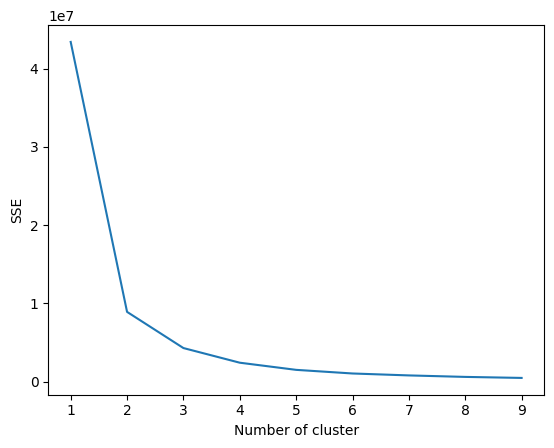

In [52]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {} # Empty dictionary to store the Sum of Squared Errors for different numbers of cluster
tx_recency = tx_user[['Recency']]

for k in range(1,10):
  kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(tx_recency)
  tx_recency["clusters"] = kmeans.labels_
  sse[k] = kmeans.inertia_ # Store the inertia (SSE) which is a measure of how spread out the cluster are (the lower the better).

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

From the graph we can conclude that the "elbow" or the optimized cluster number is 3.

In [53]:
# Build 4 cluster for recency
kmeans = KMeans(n_clusters = 5)
tx_user['RecencyCluster'] = kmeans.fit_predict(tx_user[['Recency']]) + 1

tx_user.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,RecencyCluster
0,12431,57,1
1,12791,395,5
2,12433,22,1
3,13520,80,3
4,12557,38,1


In [54]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
1,2107.0,40.353109,13.028337,22.0,29.0,39.0,51.0,68.0
2,426.0,270.838028,24.411271,228.0,249.0,271.0,290.0,314.0
3,1002.0,96.267465,18.913662,69.0,81.0,93.0,109.0,139.0
4,516.0,183.232558,25.261356,141.0,160.0,183.0,206.0,227.0
5,289.0,357.920415,26.863154,316.0,333.0,353.0,387.0,395.0


The cluster is still in randomly assignmed. We need to give clusters according to most recent transactions.

First, need to find the mean of recency value corresponding to each cluster. Then sort the values.

From the above table:
cluster 3 > cluster 1 > cluster 0 > cluster 2
So we need to change accordingly:
- Cluster 3 -> Cluster 0
- Cluster 1 -> Cluster 1
- Cluster 0 -> Cluster 2
- Cluster 2 -> Cluster 3

In [55]:
# Ordering cluster number
def order_cluster(cluster_field_name, target_field_name, data, ascending):
  new_cluster_field_name = 'new_' + cluster_field_name
  data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
  data_new = data_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
  data_new['index'] = data_new.index + 1
  data_final = pd.merge(data, data_new[[cluster_field_name, 'index']], on=cluster_field_name)
  data_final = data_final.drop([cluster_field_name], axis=1)
  data_final = data_final.rename(columns={"index": cluster_field_name})
  return data_final

In [56]:
tx_user = order_cluster('RecencyCluster', 'Recency', tx_user, False)

tx_user.head()

,CustomerID,Recency,RecencyCluster
0,12431,57,5
1,12433,22,5
2,12557,38,5
3,12779,59,5
4,12395,41,5


In [57]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
1,289.0,357.920415,26.863154,316.0,333.0,353.0,387.0,395.0
2,426.0,270.838028,24.411271,228.0,249.0,271.0,290.0,314.0
3,516.0,183.232558,25.261356,141.0,160.0,183.0,206.0,227.0
4,1002.0,96.267465,18.913662,69.0,81.0,93.0,109.0,139.0
5,2107.0,40.353109,13.028337,22.0,29.0,39.0,51.0,68.0


## Frequency
We need to find total number orders for each customer.

In [58]:
# Calculate total order for each user
tx_frequency = df_cleaned.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID', 'Frequency']

tx_frequency.head()

,CustomerID,Frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [59]:
# Add to tx_user table
tx_user = pd.merge(tx_user, tx_frequency, on=['CustomerID'])

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,12431,57,5,236
1,12433,22,5,420
2,12557,38,5,33
3,12779,59,5,149
4,12395,41,5,156


Determine the right number of clusters for K-Means by elbow method.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-60-99e1c10e7d5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_frequency["clusters"] = kmeans.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-60-99e1c10e7d5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

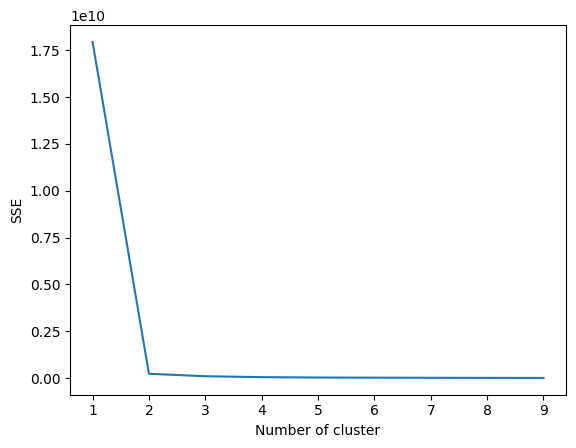

In [60]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = {}
tx_frequency = tx_user[['Frequency']]

for k in range(1,10):
  kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(tx_frequency)
  tx_frequency["clusters"] = kmeans.labels_
  sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [61]:
# Apply K-Means with 4 cluster of frequency
kmeans = KMeans(n_clusters = 5)
tx_user['FrequencyCluster'] = kmeans.fit_predict(tx_user[['Frequency']]) + 1

tx_user.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,12431,57,5,236,5
1,12433,22,5,420,5
2,12557,38,5,33,1
3,12779,59,5,149,1
4,12395,41,5,156,1


In [62]:
# Order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency', tx_user, True)

tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
1,3831.0,49.085356,43.977039,1.0,15.00,33.0,72.00,185.0
2,480.0,322.664583,131.064654,186.0,220.75,280.5,382.25,799.0
3,24.0,1323.666667,494.825456,851.0,971.50,1128.0,1535.75,2700.0
4,4.0,5807.750000,1429.386203,4596.0,4982.25,5394.0,6219.50,7847.0
5,1.0,133206.000000,NaN,133206.0,133206.00,133206.0,133206.00,133206.0


### Found an outlier!

I already calculate the Frequency for RFM but found an outliner in the frequency of order. I guess it is because of the CustomerID 99999.

Outlier problem fixed. Can ignore this part.

In [ ]:
# Check whether CustomerID 99999 is really an outlier
Q1 = tx_user['Frequency'].quantile(0.25)
Q3 = tx_user['Frequency'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = tx_user[(tx_user['Frequency'] < lower_bound) | (tx_user['Frequency'] > upper_bound)]

outliers

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850,371,0,297,1
10,12583,2,5,247,1
12,14688,7,5,327,1
13,12431,35,5,236,1
16,15513,32,5,308,1
...,...,...,...,...,...
4335,99999,0,5,133206,5
4336,12748,0,5,4596,4
4337,14911,0,5,5677,4
4338,17841,1,5,7847,4


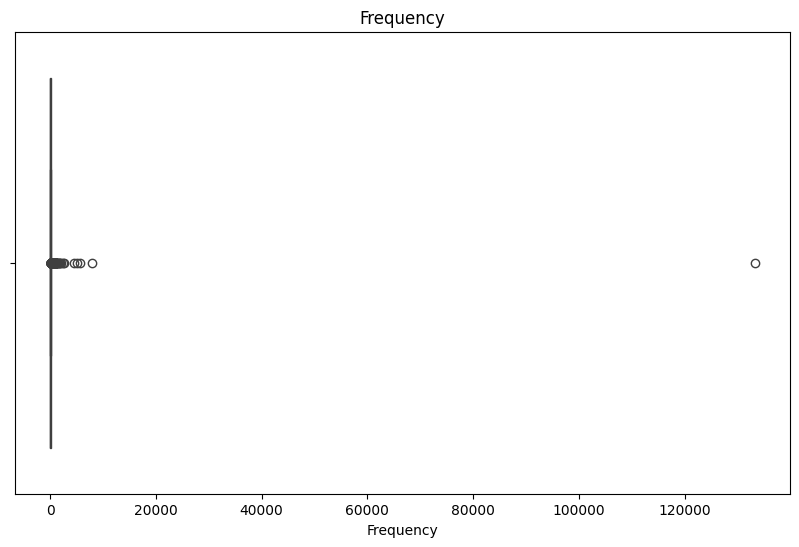

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Frequency')
sns.boxplot(x=tx_user['Frequency'])
plt.show()

Need to drop CustomerID 99999 and re-calculate the Recency.

In [ ]:
# Drop rows where CustomerID is 99999
print('Before dropping:\n', df_cleaned.shape[0])

df_cleaned = df_cleaned[df_cleaned['CustomerID'] != 99999]

print('After dropping:\n', df_cleaned.shape[0])

Before dropping:
 531130
After dropping:
 397924


In [ ]:
# Calculate percentage of data used
print('Percentage of data used: {:.2%}'.format(df_cleaned.shape[0]/df.shape[0]))

Percentage of data used: 73.43%


But first, let's update the BigQuery 😏

In [ ]:
from google.cloud import bigquery
import pandas as pd
from pandas_gbq import to_gbq

# Initialize the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Dataset and table details
dataset_id = 'retail'
table_id = 'transaction_cleaned'
table_full_id = f"{project_id}.{dataset_id}.{table_id}"

# Create the dataset if it doesn't exist
dataset_ref = client.dataset(dataset_id)
try:
    client.get_dataset(dataset_ref)
    print(f"Dataset {dataset_id} already exists.")
except NotFound:
    dataset = bigquery.Dataset(dataset_ref)
    dataset = client.create_dataset(dataset)
    print(f"Created dataset {dataset_id}.")

# Upload the DataFrame to BigQuery
to_gbq(df_cleaned, table_full_id, project_id=project_id, if_exists='replace')

Dataset retail already exists.


100%|██████████| 1/1 [00:00<00:00, 8128.50it/s]


## Re-calculate RFM
After dropping invalid customer

In [ ]:
# I'm too lazy to re-type all of that so I just re-run the RF instead

## Revenue

In [63]:
# Calculate revenue for each customer
df_cleaned['Revenue'] = df_cleaned['UnitPrice'] * df_cleaned['Quantity']

tx_revenue = df_cleaned.groupby('CustomerID').Revenue.sum().reset_index()

tx_revenue.head()

,CustomerID,Revenue
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [64]:
# Merge with tx_user
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,12431,57,5,236,2,6512.41
1,12433,22,5,420,2,13375.87
2,12766,25,5,310,2,6989.63
3,17097,24,5,211,2,954.42
4,12753,44,5,197,2,21429.39


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-65-cd5224b209f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_recency["clusters"] = kmeans.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-65-cd5224b209f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

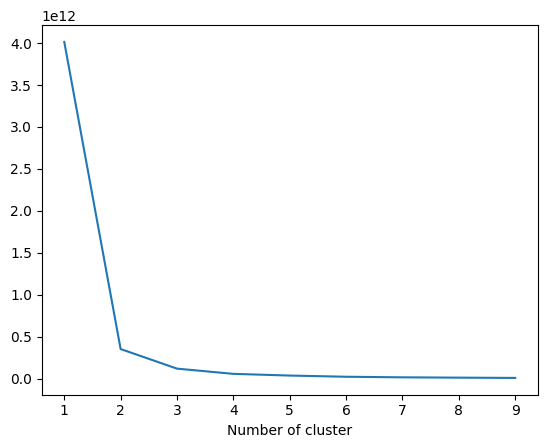

In [65]:
# Using elbow method to calculate number of clusters for K-Means
sse = {}
tx_recency = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [66]:
# Apply 4 clustering
kmeans = KMeans(n_clusters = 5)
tx_user['RevenueCluster'] = kmeans.fit_predict(tx_user[['Revenue']]) + 1

tx_user.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12431,57,5,236,2,6512.41,1
1,12433,22,5,420,2,13375.87,1
2,12766,25,5,310,2,6989.63,1
3,17097,24,5,211,2,954.42,1
4,12753,44,5,197,2,21429.39,1


In [67]:
# Order the cluster number
tx_user = order_cluster('RevenueCluster', 'Revenue', tx_user, True)

tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
1,4301.0,1.440398e+03,2231.636432,3.75,306.45,664.54,1620.930,21429.39
2,31.0,4.639945e+04,17863.921395,25977.16,31870.25,40991.57,58668.155,91062.38
3,5.0,1.501387e+05,31640.743166,117379.63,125838.77,144451.76,168472.500,194550.79
4,2.0,2.703219e+05,15082.021957,259657.30,264989.60,270321.90,275654.200,280986.50
5,1.0,1.915958e+06,NaN,1915957.99,1915957.99,1915957.99,1915957.990,1915957.99


## Overal score based on RFM clustering

In [68]:
# Calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

tx_user.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
3,357.937063,22.923077,3.578401e+02
4,271.469626,25.570093,6.914501e+02
5,183.610672,35.371542,7.260067e+02
6,97.383110,48.072091,1.020776e+03
7,43.220641,71.042112,1.447024e+03
8,35.081535,323.434053,5.543047e+03
9,29.774194,812.225806,2.785359e+04
10,29.857143,1268.285714,8.730122e+04
11,24.800000,3877.000000,1.033829e+05


In [69]:
# Calculate RFM score
tx_user['RFM_Score'] = (tx_user['RecencyCluster'].astype(str) + tx_user['FrequencyCluster'].astype(str) + tx_user['RevenueCluster'].astype(str)).astype(int)
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score
0,12431,57,5,236,2,6512.41,1,8,521
1,12433,22,5,420,2,13375.87,1,8,521
2,12766,25,5,310,2,6989.63,1,8,521
3,17097,24,5,211,2,954.42,1,8,521
4,12753,44,5,197,2,21429.39,1,8,521


In [70]:
rfm_map = {
    r'[45]{3}': 'Champions', # 555 554 544 545 454 455 445
    r'[345]{3}': 'Loyal Customers', # 543 444 435 355 354 345 344 335
    r'[345][2345][123]': 'Potential Loyalist',
    r'[345][12][12]': 'New Customers',
    r'[345][125][12345]': 'Promising',
    r'[345][234][345]': 'Need Attention',
    r'[23][12345]1': 'About to Sleep',
    r'[12][145][345]': 'Cannot Lose',
    r'[123][2345][2345]': 'At Risk',
    r'[123][123][23]': 'Hibernating',
    r'1[12345][12]': 'Lost Customers'
}

tx_user['RFM_Score'] = tx_user['RFM_Score'].replace(rfm_map, regex=True)
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score
0,12431,57,5,236,2,6512.41,1,8,521
1,12433,22,5,420,2,13375.87,1,8,521
2,12766,25,5,310,2,6989.63,1,8,521
3,17097,24,5,211,2,954.42,1,8,521
4,12753,44,5,197,2,21429.39,1,8,521


In [71]:
# Creation of Segment Variable
tx_user['RFM_Segment'] = tx_user['RecencyCluster'].astype(str) + tx_user['FrequencyCluster'].astype(str) + tx_user['RevenueCluster'].astype(str)
tx_user['RFM_Segment'] = tx_user['RFM_Segment'].replace(rfm_map, regex=True)
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score,RFM_Segment
0,12431,57,5,236,2,6512.41,1,8,521,Potential Loyalist
1,12433,22,5,420,2,13375.87,1,8,521,Potential Loyalist
2,12766,25,5,310,2,6989.63,1,8,521,Potential Loyalist
3,17097,24,5,211,2,954.42,1,8,521,Potential Loyalist
4,12753,44,5,197,2,21429.39,1,8,521,Potential Loyalist


In [72]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Cant Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

tx_user['RFM_Score'] = tx_user['RFM_Score'].replace(seg_map, regex=True)
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score,RFM_Segment
0,12431,57,5,236,2,6512.41,1,8,521,Potential Loyalist
1,12433,22,5,420,2,13375.87,1,8,521,Potential Loyalist
2,12766,25,5,310,2,6989.63,1,8,521,Potential Loyalist
3,17097,24,5,211,2,954.42,1,8,521,Potential Loyalist
4,12753,44,5,197,2,21429.39,1,8,521,Potential Loyalist


In [73]:
# Creation of Segment Variable
tx_user['RF_Segment'] = tx_user['RecencyCluster'].astype(str) + tx_user['FrequencyCluster'].astype(str)
tx_user['RF_Segment'] = tx_user['RF_Segment'].replace(seg_map, regex=True)
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score,RFM_Segment,RF_Segment
0,12431,57,5,236,2,6512.41,1,8,521,Potential Loyalist,Potential Loyalists
1,12433,22,5,420,2,13375.87,1,8,521,Potential Loyalist,Potential Loyalists
2,12766,25,5,310,2,6989.63,1,8,521,Potential Loyalist,Potential Loyalists
3,17097,24,5,211,2,954.42,1,8,521,Potential Loyalist,Potential Loyalists
4,12753,44,5,197,2,21429.39,1,8,521,Potential Loyalist,Potential Loyalists


In [74]:
# Calculate quantiles for segmentation
quantiles = tx_user['RFM_Score'].quantile([0.33, 0.66]).values

# Define a function to assign segments based on quantiles
def segment_rfm(score):
    if score <= quantiles[0]:
        return 'Low'
    elif score <= quantiles[1]:
        return 'Mid'
    else:
        return 'High'

# Apply the segmentation function
tx_user['Segment'] = tx_user['RFM_Score'].apply(segment_rfm)
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score,RFM_Segment,RF_Segment,Segment
0,12431,57,5,236,2,6512.41,1,8,521,Potential Loyalist,Potential Loyalists,High
1,12433,22,5,420,2,13375.87,1,8,521,Potential Loyalist,Potential Loyalists,High
2,12766,25,5,310,2,6989.63,1,8,521,Potential Loyalist,Potential Loyalists,High
3,17097,24,5,211,2,954.42,1,8,521,Potential Loyalist,Potential Loyalists,High
4,12753,44,5,197,2,21429.39,1,8,521,Potential Loyalist,Potential Loyalists,High


In [75]:
tx_user[['RFM_Segment', 'Recency', 'Frequency', 'Revenue']].groupby('RFM_Segment').agg(['mean', 'count'])

Recency            Frequency             Revenue      
                          mean count           mean count          mean count
RFM_Segment                                                                  
About to Sleep      270.870588   425      24.560000   425  4.932491e+02   425
Champions            22.000000     1  133206.000000     1  1.915958e+06     1
Hibernating         302.000000     2       5.500000     2  6.085895e+04     2
Lost Customers      357.958333   288      24.517361   288  3.870432e+02   288
Loyal Customers      25.666667     3    3052.333333     3  1.809393e+05     3
New Customers        81.743343  3117      54.872634  3117  1.243039e+03  3117
Potential Loyalist   42.021912   502     397.978088   502  7.244132e+03   502
Promising            22.000000     2     217.000000     2  2.140649e+05     2

In [76]:
tx_user[['RF_Segment', 'Recency', 'Frequency']].groupby('RF_Segment').agg(['mean', 'count'])

Recency           Frequency      
                           mean count          mean count
RF_Segment                                               
About to Sleep       183.232558   516     39.949612   516
Champions             23.200000     5  31287.400000     5
Hibernating          306.036364   715     24.489510   715
New Customers         41.949758  1652     66.100484  1652
Potential Loyalists   39.443089   492    372.802846   492
Promising             96.521875   960     45.783333   960

## Push RFM Table to BigQuery

In [77]:
from google.cloud import bigquery
import pandas as pd
from pandas_gbq import to_gbq

# Initialize the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Dataset and table details
dataset_id = 'retail'
table_id = 'rfm_segmentation'
table_full_id = f"{project_id}.{dataset_id}.{table_id}"

# Create the dataset if it doesn't exist
dataset_ref = client.dataset(dataset_id)
try:
    client.get_dataset(dataset_ref)
    print(f"Dataset {dataset_id} already exists.")
except NotFound:
    dataset = bigquery.Dataset(dataset_ref)
    dataset = client.create_dataset(dataset)
    print(f"Created dataset {dataset_id}.")

# Upload the DataFrame to BigQuery
to_gbq(tx_user, table_full_id, project_id=project_id, if_exists='replace')

Dataset retail already exists.


100%|██████████| 1/1 [00:00<00:00, 6069.90it/s]


# RFM Final Code

In [ ]:
# Install necessary libraries
!pip install google-cloud-bigquery
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [85]:
# Authenticate and setup Google Cloud SDK
from google.colab import auth

from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

In [86]:
# Load data from BigQuery
query = """
SELECT *
FROM `finalproject-g2df12.retail.raw_dataiku`
"""

# Load data into a DataFrame
rfm_df = client.query(query).to_dataframe()

In [87]:
# Preprocessing
rfm_df = rfm_df.dropna(subset=['CustomerID'])
rfm_df['CustomerID'] = rfm_df['CustomerID'].astype('int64')
rfm_df = rfm_df[~rfm_df['InvoiceNo'].str.startswith('C')]

<ipython-input-87-2c9e96ee488a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['CustomerID'] = rfm_df['CustomerID'].astype('int64')


In [88]:
# Perform RFM segmentation
# Calculate total purchase each transaction
rfm_df['TotalPurchase'] = rfm_df['UnitPrice'] * rfm_df['Quantity']

# Define the current date
current_date = pd.to_datetime('2012-01-01')

# Calculate the difference between the current date and the invoice date
rfm = rfm_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (current_date - date.max()).days,
    'InvoiceNo': lambda num: len(num),
    'TotalPurchase': lambda price: price.sum()
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()

In [89]:
# Define RFM score calculation
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop').astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)

# Calculate RFM score
rfm['RFM_Score'] = (rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)).astype(int)

In [90]:
# Calculate quantiles for segmentation
quantiles = rfm['RFM_Score'].quantile([0.33, 0.66]).values

# Define a function to assign segments based on quantiles
def segment_rfm(score):
    if score <= quantiles[0]:
        return 'Low'
    elif score <= quantiles[1]:
        return 'Mid'
    else:
        return 'High'

# Apply the segmentation function
rfm['Segment'] = rfm['RFM_Score'].apply(segment_rfm)

In [91]:
rfm_map = {
    r'[45]{3}': 'Champions', # 555 554 544 545 454 455 445
    r'[345]{3}': 'Loyal Customers', # 543 444 435 355 354 345 344 335
    r'[345][2345][123]': 'Potential Loyalist',
    r'[345][12][12]': 'New Customers',
    r'[345][125][12345]': 'Promising',
    r'[345][234][345]': 'Need Attention',
    r'[23][12345]1': 'About to Sleep',
    r'[12][145][345]': 'Cannot Lose',
    r'[123][2345][2345]': 'At Risk',
    r'[123][123][23]': 'Hibernating',
    r'1[12345][12]': 'Lost Customers'
}

rfm['RFM_Score'] = rfm['RFM_Score'].replace(rfm_map, regex=True)

# Creation of Segment Variable
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Segment'] = rfm['RFM_Segment'].replace(rfm_map, regex=True)

In [34]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,RFM_Segment
0,12346,347,2,0.0,1,1,1,111,Low,Lost Customers
1,12347,24,182,4310.0,5,5,5,555,High,Champions
2,12348,97,31,1797.24,2,3,4,234,Mid,At Risk
3,12349,40,73,1757.55,4,4,4,444,High,Champions
4,12350,332,17,334.4,1,2,2,122,Low,At Risk


In [92]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Cant Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['RFM_Score'] = rfm['RFM_Score'].replace(seg_map, regex=True)

# Creation of Segment Variable
rfm['RF_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str)
rfm['RF_Segment'] = rfm['RF_Segment'].replace(seg_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,RFM_Segment,RF_Segment
0,12346,347,1,77183.6,1,1,5,115,Low,Cannot Lose,Hibernating
1,12347,24,182,4310.0,5,5,5,555,High,Champions,Champions
2,12348,97,31,1797.24,2,3,4,234,Mid,At Risk,At Risk
3,12349,40,73,1757.55,4,4,4,444,High,Champions,Loyal Customers
4,12350,332,17,334.4,1,2,2,122,Low,At Risk,Hibernating


In [93]:
rfm.dtypes

CustomerID       int64
Recency          int64
Frequency        int64
Monetary       Float64
R_Score          int64
F_Score          int64
M_Score          int64
RFM_Score        int64
Segment         object
RFM_Segment     object
RF_Segment      object
dtype: object

In [94]:
from google.cloud import bigquery
import pandas as pd
from pandas_gbq import to_gbq

# Initialize the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Dataset and table details
dataset_id = 'retail'
table_id = 'rfm_segmentation'
table_full_id = f"{project_id}.{dataset_id}.{table_id}"

# Create the dataset if it doesn't exist
dataset_ref = client.dataset(dataset_id)
try:
    client.get_dataset(dataset_ref)
    print(f"Dataset {dataset_id} already exists.")
except NotFound:
    dataset = bigquery.Dataset(dataset_ref)
    dataset = client.create_dataset(dataset)
    print(f"Created dataset {dataset_id}.")

# Upload the DataFrame to BigQuery
to_gbq(rfm, table_full_id, project_id=project_id, if_exists='replace')

Dataset retail already exists.


100%|██████████| 1/1 [00:00<00:00, 6335.81it/s]


# CLV

## CLV Calculation based on equation

In [ ]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score,RFM_Segment,RF_Segment,Segment
0,12431,57,5,236,2,6512.41,1,8,521,Potential Loyalist,Potential Loyalists,High
1,12433,22,5,420,2,13375.87,1,8,521,Potential Loyalist,Potential Loyalists,High
2,12766,25,5,310,2,6989.63,1,8,521,Potential Loyalist,Potential Loyalists,High
3,17097,24,5,211,2,954.42,1,8,521,Potential Loyalist,Potential Loyalists,High
4,12753,44,5,197,2,21429.39,1,8,521,Potential Loyalist,Potential Loyalists,High


**Average Order Value(AOV):** <br>
The Average Order value is the ratio of your total revenue and the total number of orders. <br>
AOV represents the mean amount of revenue that the customer spends on an order.

In [ ]:
# Average Order Value
tx_user['AOV'] = tx_user['Revenue'] / tx_user['Frequency']
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score,RFM_Segment,RF_Segment,Segment,AOV
0,12431,57,5,236,2,6512.41,1,8,521,Potential Loyalist,Potential Loyalists,High,27.594958
1,12433,22,5,420,2,13375.87,1,8,521,Potential Loyalist,Potential Loyalists,High,31.847310
2,12766,25,5,310,2,6989.63,1,8,521,Potential Loyalist,Potential Loyalists,High,22.547194
3,17097,24,5,211,2,954.42,1,8,521,Potential Loyalist,Potential Loyalists,High,4.523318
4,12753,44,5,197,2,21429.39,1,8,521,Potential Loyalist,Potential Loyalists,High,108.778629


**Purchase Frequency(PF)**: <br>
Purchase Frequency is the ratio of the total number of orders and the total number of customer.

It represents the average number of orders placed by each customer.

In [ ]:
# Calculate Purchase Frequency
purchase_frequency = sum(tx_user['Frequency']) / tx_user.shape[0]

print('The average number of orders for each customer:', purchase_frequency)

The average number of orders for each customer: 122.38018433179724


**Repeat Rate:** <br>
Repeat rate can be defined as the ratio of the number of customers with more than one order to the number of unique customers.

Example: If you have 10 customers in a month out of who 4 come back, your repeat rate is 40%.

In [ ]:
# Calculate repeat rate
repeat_rate = tx_user[tx_user.Frequency > 1].shape[0] / tx_user.shape[0]

print("Repeat rate customer: {:.2%}".format(tx_user[tx_user.Frequency > 1].shape[0] / tx_user.shape[0]))

Repeat rate customer: 98.34%


**Churn Rate:** <br>
Churn Rate is the percentage of customers who have not ordered again.

In [ ]:
# Calculate churn rate
churn_rate = 100 - repeat_rate

print("Churn rate customer: {:.2%}".format(1 - repeat_rate))

Churn rate customer: 1.66%


Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain.

Let's assume our business has approx 5% profit on the total sale.

In [ ]:
# Calculate Profit Margin
tx_user['profit_margin'] = tx_user['Revenue'] * 0.05

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score,RFM_Segment,RF_Segment,Segment,AOV,profit_margin
0,12431,57,5,236,2,6512.41,1,8,521,Potential Loyalist,Potential Loyalists,High,27.594958,325.6205
1,12433,22,5,420,2,13375.87,1,8,521,Potential Loyalist,Potential Loyalists,High,31.847310,668.7935
2,12766,25,5,310,2,6989.63,1,8,521,Potential Loyalist,Potential Loyalists,High,22.547194,349.4815
3,17097,24,5,211,2,954.42,1,8,521,Potential Loyalist,Potential Loyalists,High,4.523318,47.7210
4,12753,44,5,197,2,21429.39,1,8,521,Potential Loyalist,Potential Loyalists,High,108.778629,1071.4695


Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 5% profit on the total sale.




In [ ]:
# Calculate Customer Value
tx_user['CV'] = (tx_user['AOV'] * purchase_frequency) / churn_rate

# Calculate Customer Lifetime Value
tx_user['CLV'] = tx_user['CV'] * tx_user['profit_margin']

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,RFM_Score,RFM_Segment,RF_Segment,Segment,AOV,profit_margin,CV,CLV
0,12431,57,5,236,2,6512.41,1,8,521,Potential Loyalist,Potential Loyalists,High,27.594958,325.6205,34.106163,11105.666005
1,12433,22,5,420,2,13375.87,1,8,521,Potential Loyalist,Potential Loyalists,High,31.847310,668.7935,39.361885,26324.972746
2,12766,25,5,310,2,6989.63,1,8,521,Potential Loyalist,Potential Loyalists,High,22.547194,349.4815,27.867347,9739.122351
3,17097,24,5,211,2,954.42,1,8,521,Potential Loyalist,Potential Loyalists,High,4.523318,47.7210,5.590623,266.790125
4,12753,44,5,197,2,21429.39,1,8,521,Potential Loyalist,Potential Loyalists,High,108.778629,1071.4695,134.445639,144054.401887


## CLV Test

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
data = df_cleaned.copy()

In [ ]:
# Remove data with CustomerID = 99999
data = data[data['CustomerID'] != 99999]
data = data[~data['InvoiceNo'].str.startswith('C')]

In [ ]:
# Calculate Total Price
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [ ]:
cutoff_date = '2011-07-01'
past_data = data[data['InvoiceDate'] < cutoff_date]
future_data = data[data['InvoiceDate'] >= cutoff_date]

In [ ]:
past_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear,TotalPrice
0,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6.0,2010-12-01 10:03:00+00:00,8.50,12431,Australia,2010,12,1,2,48,51.0
1,536389,21622,VINTAGE UNION JACK CUSHION COVER,8.0,2010-12-01 10:03:00+00:00,4.95,12431,Australia,2010,12,1,2,48,39.6
2,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-12-01 10:03:00+00:00,1.25,12431,Australia,2010,12,1,2,48,15.0
3,536389,35004,SET OF 3 COLOURED FLYING DUCKS,6.0,2010-12-01 10:03:00+00:00,5.45,12431,Australia,2010,12,1,2,48,32.7
4,536389,35004,SET OF 3 GOLD FLYING DUCKS,4.0,2010-12-01 10:03:00+00:00,6.35,12431,Australia,2010,12,1,2,48,25.4


In [ ]:
now = past_data['InvoiceDate'].max() + pd.Timedelta(days=1)
past_data['DaysSinceLastPurchase'] = (now - past_data['InvoiceDate']).dt.days

recency = past_data.groupby('CustomerID')['DaysSinceLastPurchase'].min().reset_index()
recency.columns = ['CustomerID', 'Recency']

frequency = past_data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

monetary = past_data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
rfm.head()

<ipython-input-27-9b90a3268eb8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['DaysSinceLastPurchase'] = (now - past_data['InvoiceDate']).dt.days


,CustomerID,Recency,Frequency,Monetary
0,12346,164,1,77183.60
1,12347,22,4,2205.95
2,12348,87,3,1487.24
3,12350,149,1,334.40
4,12352,101,5,1561.81


In [ ]:
future_revenue = future_data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
future_revenue.columns = ['CustomerID', 'FutureRevenue']

In [ ]:
rfm = rfm.merge(future_revenue, on='CustomerID', how='left')
rfm['FutureRevenue'] = rfm['FutureRevenue'].fillna(0)  # Fill NA with 0 if no future transactions

rfm.head()

,CustomerID,Recency,Frequency,Monetary,FutureRevenue
0,12346,164,1,77183.60,0.00
1,12347,22,4,2205.95,2104.05
2,12348,87,3,1487.24,310.00
3,12350,149,1,334.40,0.00
4,12352,101,5,1561.81,944.23


In [ ]:
rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm['RFMScore'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,FutureRevenue,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
0,12346,164,1,77183.60,0.00,1,1,5,115
1,12347,22,4,2205.95,2104.05,4,4,5,445
2,12348,87,3,1487.24,310.00,2,4,5,245
3,12350,149,1,334.40,0.00,1,1,2,112
4,12352,101,5,1561.81,944.23,2,5,5,255


In [ ]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['FutureRevenue']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 22267236.403215267
R^2 Score: -2.3987562194809797


In [ ]:
# Predict future revenue for the test set
y_pred = model.predict(X_test)

# Create a DataFrame to compare actual vs. predicted future revenue
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.head(10)

,Actual,Predicted
2012,1199.21,135.3736
1688,613.71,338.6147
764,159.20,319.7236
2058,68.00,130.9566
2025,622.24,1237.4730
2236,0.00,312.8764
807,0.00,666.9295
2416,659.14,1299.0059
1582,786.02,127.7769
332,76.32,193.9675


## CLV Prediction Datacamp

In [ ]:
df_cleaned['month_year'] = df_cleaned['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,month_year
0,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6.0,2010-12-01 10:03:00+00:00,8.50,12431,Australia,2010,12,1,2,48,51.0,Dec-2010
1,536389,21622,VINTAGE UNION JACK CUSHION COVER,8.0,2010-12-01 10:03:00+00:00,4.95,12431,Australia,2010,12,1,2,48,39.6,Dec-2010
2,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-12-01 10:03:00+00:00,1.25,12431,Australia,2010,12,1,2,48,15.0,Dec-2010
3,536389,35004,SET OF 3 COLOURED FLYING DUCKS,6.0,2010-12-01 10:03:00+00:00,5.45,12431,Australia,2010,12,1,2,48,32.7,Dec-2010
4,536389,35004,SET OF 3 GOLD FLYING DUCKS,4.0,2010-12-01 10:03:00+00:00,6.35,12431,Australia,2010,12,1,2,48,25.4,Dec-2010


In [ ]:
df_cleaned['TotalPurchase'] = df_cleaned['UnitPrice'] * df_cleaned['Quantity']

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,month_year,TotalPurchase,Date
0,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6.0,2010-12-01 10:03:00+00:00,8.50,12431,Australia,2010,12,1,2,48,51.0,Dec-2010,51.0,2010-12-01
1,536389,21622,VINTAGE UNION JACK CUSHION COVER,8.0,2010-12-01 10:03:00+00:00,4.95,12431,Australia,2010,12,1,2,48,39.6,Dec-2010,39.6,2010-12-01
2,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-12-01 10:03:00+00:00,1.25,12431,Australia,2010,12,1,2,48,15.0,Dec-2010,15.0,2010-12-01
3,536389,35004,SET OF 3 COLOURED FLYING DUCKS,6.0,2010-12-01 10:03:00+00:00,5.45,12431,Australia,2010,12,1,2,48,32.7,Dec-2010,32.7,2010-12-01
4,536389,35004,SET OF 3 GOLD FLYING DUCKS,4.0,2010-12-01 10:03:00+00:00,6.35,12431,Australia,2010,12,1,2,48,25.4,Dec-2010,25.4,2010-12-01


In [ ]:
sale = df_cleaned.pivot_table(index=['CustomerID'], columns=['month_year'], values=['TotalPurchase'], aggfunc='sum', fill_value=0).reset_index()

sale.head()

CustomerID TotalPurchase                                      \
month_year                 Apr-2011 Aug-2011 Dec-2010 Dec-2011 Feb-2011   
0               12346          0.00     0.00     0.00     0.00      0.0   
1               12347        636.25   584.91   711.79   224.82      0.0   
2               12348        367.00     0.00   892.80     0.00      0.0   
3               12349          0.00     0.00     0.00     0.00      0.0   
4               12350          0.00     0.00     0.00     0.00    334.4   

                                                                            \
month_year  Jan-2011 Jul-2011 Jun-2011 Mar-2011 May-2011 Nov-2011 Oct-2011   
0           77183.60      0.0     0.00      0.0      0.0     0.00     0.00   
1             475.39      0.0   382.52      0.0      0.0     0.00  1294.32   
2             227.44      0.0     0.00      0.0      0.0     0.00     0.00   
3               0.00      0.0     0.00      0.0      0.0  1757.55     0.00   
4               0.00      0.0     0.00      0.0      0.0     0.00     0.00   

                     
month_year Sep-2011  
0               0.0  
1               0.0  
2             310.0  
3               0.0  
4               0.0

In [ ]:
sale['CLV'] = sale.iloc[:,2:].sum(axis=1)

sale.head()

CustomerID TotalPurchase                                      \
month_year                 Apr-2011 Aug-2011 Dec-2010 Dec-2011 Feb-2011   
0               12346          0.00     0.00     0.00     0.00      0.0   
1               12347        636.25   584.91   711.79   224.82      0.0   
2               12348        367.00     0.00   892.80     0.00      0.0   
3               12349          0.00     0.00     0.00     0.00      0.0   
4               12350          0.00     0.00     0.00     0.00    334.4   

                                                                            \
month_year  Jan-2011 Jul-2011 Jun-2011 Mar-2011 May-2011 Nov-2011 Oct-2011   
0           77183.60      0.0     0.00      0.0      0.0     0.00     0.00   
1             475.39      0.0   382.52      0.0      0.0     0.00  1294.32   
2             227.44      0.0     0.00      0.0      0.0     0.00     0.00   
3               0.00      0.0     0.00      0.0      0.0  1757.55     0.00   
4               0.00      0.0     0.00      0.0      0.0     0.00     0.00   

                          CLV  
month_year Sep-2011            
0               0.0  77183.60  
1               0.0   3673.75  
2             310.0   1430.24  
3               0.0   1757.55  
4               0.0    334.40

In [ ]:
# Feature columns to be selected
feature_columns = [('TotalPurchase', 'Dec-2011'),
                   ('TotalPurchase', 'Nov-2011'),
                   ('TotalPurchase', 'Oct-2011'),
                   ('TotalPurchase', 'Sep-2011'),
                   ('TotalPurchase', 'Aug-2011'),
                   ('TotalPurchase', 'Jul-2011')]

# Selecting the feature matrix X
X = sale[feature_columns]

# Selecting the target variable y
y = sale[('CLV')]

In [ ]:
# Split the training set and test set
from sklearn.model_selection import train_test_split

# Assuming X and y have been defined as per the previous steps
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [ ]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

-82.02134346797538
[1.01539379 2.06193529 1.80470123 1.02108369 2.61244358 2.25354607]


In [ ]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.6958689008126435


For regression problems following evaluation metrics used (Ritchie Ng):

- Mean Absolute Error (MAE) is the mean of the absolute value of the errors.
- Mean Squared Error (MSE) is the mean of the squared errors.
- Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.

In [ ]:
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 727.6049705590495
MSE 7400947.515475433
RMSE: 2720.4682529806214


## CLV Kaggle
https://www.kaggle.com/code/shailaja4247/customer-lifetime-value-prediction#notebook-container

In [ ]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,month_year,TotalPurchase
0,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6.0,2010-12-01 10:03:00+00:00,8.50,12431,Australia,2010,12,1,2,48,51.0,Dec-2010,51.0
1,536389,21622,VINTAGE UNION JACK CUSHION COVER,8.0,2010-12-01 10:03:00+00:00,4.95,12431,Australia,2010,12,1,2,48,39.6,Dec-2010,39.6
2,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-12-01 10:03:00+00:00,1.25,12431,Australia,2010,12,1,2,48,15.0,Dec-2010,15.0
3,536389,35004,SET OF 3 COLOURED FLYING DUCKS,6.0,2010-12-01 10:03:00+00:00,5.45,12431,Australia,2010,12,1,2,48,32.7,Dec-2010,32.7
4,536389,35004,SET OF 3 GOLD FLYING DUCKS,4.0,2010-12-01 10:03:00+00:00,6.35,12431,Australia,2010,12,1,2,48,25.4,Dec-2010,25.4


In [ ]:
df_cleaned['Date'] = pd.to_datetime(df_cleaned['InvoiceDate']).dt.date
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,month_year,TotalPurchase,Date
0,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6.0,2010-12-01 10:03:00+00:00,8.50,12431,Australia,2010,12,1,2,48,51.0,Dec-2010,51.0,2010-12-01
1,536389,21622,VINTAGE UNION JACK CUSHION COVER,8.0,2010-12-01 10:03:00+00:00,4.95,12431,Australia,2010,12,1,2,48,39.6,Dec-2010,39.6,2010-12-01
2,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-12-01 10:03:00+00:00,1.25,12431,Australia,2010,12,1,2,48,15.0,Dec-2010,15.0,2010-12-01
3,536389,35004,SET OF 3 COLOURED FLYING DUCKS,6.0,2010-12-01 10:03:00+00:00,5.45,12431,Australia,2010,12,1,2,48,32.7,Dec-2010,32.7,2010-12-01
4,536389,35004,SET OF 3 GOLD FLYING DUCKS,4.0,2010-12-01 10:03:00+00:00,6.35,12431,Australia,2010,12,1,2,48,25.4,Dec-2010,25.4,2010-12-01


In [ ]:
tx_q = df_cleaned[(df_cleaned.Date >= date(2011,3,1)) & (df_cleaned.Date < date(2011,6,1))].reset_index(drop=True)

# CLV Arfi

Lifetime Value = Total Gross Revenue - Total Cost

In [ ]:
df_cleaned['InvoiceDate'].describe()

count                           397924
mean     2011-07-10 23:43:36.912475648
min                2010-12-01 08:26:00
25%                2011-04-07 11:12:00
50%                2011-07-31 14:39:00
75%                2011-10-20 14:33:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

if the customers are active from 1 dec 2010, then let us consider from April onward (we take the quarter and in April they are not a new consumers)

In [ ]:
df_cleaned['Date'] = pd.to_datetime(df_cleaned['InvoiceDate']).dt.date

In [ ]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,Date
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,48,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48,20.34,2010-12-01
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,48,22.00,2010-12-01
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48,20.34,2010-12-01
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48,20.34,2010-12-01


In [ ]:
tx_q = df_cleaned[(df_cleaned.Date < date(2011,6,1)) & (df_cleaned.Date >= date(2011,3,1))].reset_index(drop=True)

In [ ]:
#calculate revenue and create a new dataframe for it
tx_q['Revenue'] = tx_q['UnitPrice'] * tx_q['Quantity']
tx_user_q = tx_q.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_q.columns = ['CustomerID','m3_Revenue']

In [ ]:
tx_user_q.head()

,CustomerID,m3_Revenue
0,12347,636.25
1,12348,367.00
2,12352,1265.31
3,12353,89.00
4,12354,1079.40


In [ ]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_q['m3_Revenue']
    )
]

plot_layout = go.Layout(
        title='Quarter Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

next we merge the quarter data

In [ ]:
tx_merge = pd.merge(tx_user, tx_user_q, on='CustomerID', how='left') #Only people who are in the timeline of tx_user_q

In [ ]:
tx_merge = tx_merge.fillna(0)

In [ ]:
tx_graph = tx_merge.query("m3_Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m3_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m3_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m3_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Quarter LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
#remove outliers
tx_merge = tx_merge[tx_merge['m3_Revenue']<tx_merge['m3_Revenue'].quantile(0.99)]

In [ ]:
tx_merge

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m3_Revenue
2,12583,2,5,247,1,7281.38,1,7,Mid-Value,1134.81
3,15291,25,5,103,1,4668.30,1,7,Mid-Value,1307.40
4,14688,7,5,327,1,5630.87,1,7,Mid-Value,1296.31
5,12431,35,5,236,1,6512.41,1,7,Mid-Value,947.25
6,13448,16,5,195,1,3539.37,1,7,Mid-Value,593.72
...,...,...,...,...,...,...,...,...,...,...
4316,12748,0,5,4596,4,33720.98,2,11,High-Value,4514.24
4317,17841,1,5,7847,4,40991.57,2,11,High-Value,6085.03
4322,17949,0,5,70,0,58510.48,3,8,Mid-Value,6880.80
4329,15061,3,5,403,2,54534.14,3,10,High-Value,8051.59


In [ ]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
tx_merge['LTVCluster'] = kmeans.fit_predict(tx_merge[['m3_Revenue']])

tx_merge.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-102-a7420583b025>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m3_Revenue,LTVCluster
2,12583,2,5,247,1,7281.38,1,7,Mid-Value,1134.81,2
3,15291,25,5,103,1,4668.30,1,7,Mid-Value,1307.40,2
4,14688,7,5,327,1,5630.87,1,7,Mid-Value,1296.31,2
5,12431,35,5,236,1,6512.41,1,7,Mid-Value,947.25,0
6,13448,16,5,195,1,3539.37,1,7,Mid-Value,593.72,0


In [ ]:
#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm3_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m3_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1615.0,385.871257,240.437606,2.90,197.0500,326.400,525.9500,1025.64
1,316.0,1651.347756,544.746986,1026.39,1235.3425,1512.955,1895.5775,3321.64
2,42.0,5028.509048,1412.415495,3377.13,3846.5100,4395.215,6297.9025,8051.59


###Modelling machine learning

In [ ]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m3_Revenue,LTVCluster
0,12583,2,5,247,1,7281.38,1,7,Mid-Value,1134.81,1
1,15291,25,5,103,1,4668.30,1,7,Mid-Value,1307.40,1
2,14688,7,5,327,1,5630.87,1,7,Mid-Value,1296.31,1
3,13468,1,5,302,1,5704.97,1,7,Mid-Value,1981.62,1
4,18229,11,5,164,1,7276.90,1,7,Mid-Value,1485.80,1


In [ ]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster, dtype=int) #There is only one categorical variable segment
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m3_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,12583,2,5,247,1,7281.38,1,7,1134.81,1,0,0,1
1,15291,25,5,103,1,4668.30,1,7,1307.40,1,0,0,1
2,14688,7,5,327,1,5630.87,1,7,1296.31,1,0,0,1
3,13468,1,5,302,1,5704.97,1,7,1981.62,1,0,0,1
4,18229,11,5,164,1,7276.90,1,7,1485.80,1,0,0,1


In [ ]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m3_Revenue            0.860747
RevenueCluster        0.646811
Revenue               0.497202
OverallScore          0.418349
FrequencyCluster      0.402877
Frequency             0.337275
Segment_High-Value    0.264751
RecencyCluster        0.226213
Segment_Mid-Value     0.206109
CustomerID           -0.074129
Recency              -0.231996
Segment_Low-Value    -0.263406
Name: LTVCluster, dtype: float64

In [ ]:
tx_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1973 entries, 0 to 1972
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1973 non-null   int64  
 1   Recency             1973 non-null   int64  
 2   RecencyCluster      1973 non-null   int64  
 3   Frequency           1973 non-null   int64  
 4   FrequencyCluster    1973 non-null   int64  
 5   Revenue             1973 non-null   float64
 6   RevenueCluster      1973 non-null   int64  
 7   OverallScore        1973 non-null   int64  
 8   m3_Revenue          1973 non-null   float64
 9   LTVCluster          1973 non-null   int64  
 10  Segment_High-Value  1973 non-null   int64  
 11  Segment_Low-Value   1973 non-null   int64  
 12  Segment_Mid-Value   1973 non-null   int64  
dtypes: float64(2), int64(11)
memory usage: 200.5 KB


In [ ]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m3_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1381 entries, 235 to 1877
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1381 non-null   int64  
 1   Recency             1381 non-null   int64  
 2   RecencyCluster      1381 non-null   int64  
 3   Frequency           1381 non-null   int64  
 4   FrequencyCluster    1381 non-null   int64  
 5   Revenue             1381 non-null   float64
 6   RevenueCluster      1381 non-null   int64  
 7   OverallScore        1381 non-null   int64  
 8   Segment_High-Value  1381 non-null   int64  
 9   Segment_Low-Value   1381 non-null   int64  
 10  Segment_Mid-Value   1381 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.5 KB


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 592 entries, 943 to 79
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          592 non-null    int64  
 1   Recency             592 non-null    int64  
 2   RecencyCluster      592 non-null    int64  
 3   Frequency           592 non-null    int64  
 4   FrequencyCluster    592 non-null    int64  
 5   Revenue             592 non-null    float64
 6   RevenueCluster      592 non-null    int64  
 7   OverallScore        592 non-null    int64  
 8   Segment_High-Value  592 non-null    int64  
 9   Segment_Low-Value   592 non-null    int64  
 10  Segment_Mid-Value   592 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 55.5 KB


In [ ]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)

Accuracy of XGB classifier on training set: 0.97
Accuracy of XGB classifier on test set: 0.89


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       494
           1       0.65      0.62      0.64        90
           2       0.60      0.75      0.67         8

    accuracy                           0.89       592
   macro avg       0.73      0.77      0.75       592
weighted avg       0.89      0.89      0.89       592



let's try another models

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
models = {
    'K-Nearest Neighbors' : KNeighborsClassifier(),
    'Logistic Regression' : LogisticRegression(max_iter=1000),
    'Random Forest' : RandomForestClassifier(),
    'Gradient Boosting' : GradientBoostingClassifier()
}

for name, model in models.items():
    print(f'{name} training started')
    model.fit(X_train, y_train)
    print(f'{name} trained')
    print("*"*40)
print("FINISHED")

K-Nearest Neighbors training started
K-Nearest Neighbors trained
****************************************
Logistic Regression training started
Logistic Regression trained
****************************************
Random Forest training started
Random Forest trained
****************************************
Gradient Boosting training started
Gradient Boosting trained
****************************************
FINISHED


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification

In [ ]:
for name in models:
    acc_score= round(accuracy_score(y_train, models.get(name).predict(X_train)), 3)
    print(f'{name} accuracy train score :  {acc_score}')

K-Nearest Neighbors accuracy train score :  0.894
Logistic Regression accuracy train score :  0.859
Random Forest accuracy train score :  1.0
Gradient Boosting accuracy train score :  0.959


In [ ]:
for name in models:
    acc_score= round(accuracy_score(y_test, models.get(name).predict(X_test)), 3)
    print(f'{name} accuracy score :  {acc_score}')

K-Nearest Neighbors accuracy score :  0.865
Logistic Regression accuracy score :  0.863
Random Forest accuracy score :  0.883
Gradient Boosting accuracy score :  0.902


In [ ]:
for name in models:
    print(f'{name} classification report')
    print("-------------------------------")
    print(classification_report(y_test, models.get(name).predict(X_test)))
    print("******************************")
    print(" ")

K-Nearest Neighbors classification report
-------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       494
           1       0.57      0.43      0.49        90
           2       0.62      0.62      0.62         8

    accuracy                           0.86       592
   macro avg       0.70      0.67      0.68       592
weighted avg       0.85      0.86      0.86       592

******************************
 
Logistic Regression classification report
-------------------------------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       494
           1       0.58      0.34      0.43        90
           2       1.00      0.38      0.55         8

    accuracy                           0.86       592
   macro avg       0.82      0.56      0.64       592
weighted avg       0.85      0.86      0.85       592

******************************
 
Random Forest classifica